In [34]:
## Imports

import json
import pickle
import polars as pl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error

In [22]:
# Define data types for each column
dtypes = {
    "date": pl.Utf8,
    "cell_ll_lat": pl.Float32,
    "cell_ll_lon": pl.Float32,
    "mmsi": pl.Int32,
    "hours": pl.Float32,
    "fishing_hours": pl.Float32,
    "flag_registry": pl.Categorical,
    "flag_gfw": pl.Categorical, 
    "vessel_class_registry": pl.Categorical,
    "season": pl.Categorical
}

# Read CSV lazily using Polars
df_lazy = pl.scan_csv('MMSI-daily_merged_2019_2020-vessels-gfw-seasons.csv', schema_overrides=dtypes)

# Drop rows where flag_registry is missing
df_lazy = df_lazy.filter(pl.col("flag_registry").is_not_null())

# Drop flag_gfw and date
df_lazy = df_lazy.drop(["flag_gfw",'date'])

In [23]:
# Sample rows to reduce memory usage (here at 5%)
df_lazy = df_lazy.with_row_index("index")
row_count_df = df_lazy.select(pl.count("index").alias("row_count")).collect()
row_count = row_count_df["row_count"][0]
sample_n = int(0.15 * row_count)
sample_indices = sorted(np.random.choice(row_count, size=sample_n, replace=False))
df_lazy = df_lazy.filter(pl.col("index").is_in(sample_indices)).drop("index")

In [24]:
# Collect the lazy frame
df_polars = df_lazy.collect()

# Convert to pandas DataFrame
df = df_polars.to_pandas()

In [25]:
# Create dummy variables for season. Since season is a key feature, we generate dummies here.
df = pd.get_dummies(df, columns=['season'], drop_first=True)

# Create dummy variables for vessel class
df = pd.get_dummies(df, columns=['vessel_class_registry'], drop_first=True)

# Define feature columns: location, hours, fishing_hours, season dummies, and vessel class dummies.
features = ['cell_ll_lat', 'cell_ll_lon', 'hours', 'fishing_hours'] + \
           [col for col in df.columns if col.startswith('season_') or col.startswith('vessel_class_registry_')]

# Target variable: flag_registry (vessel flag)
target = 'flag_registry'

# Encode the target variable
le = LabelEncoder()
df[target] = le.fit_transform(df[target])

# Define X and y
X = df[features]
y = df[target]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=20)

# Deleting unnecessary dataframes to free up memory
del df, df_lazy, df_polars

In [26]:
# Logistic Regression Model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
lr_preds = lr_model.predict(X_test)
lr_rmse = mean_squared_error(y_test, lr_preds, squared=False)
print(f'Linear Regression RMSE: {lr_rmse}')

Linear Regression RMSE: 30.695089700861498


In [27]:
# Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=5, random_state=20, n_jobs=-1)
rf_model.fit(X_train, y_train)
rf_preds = rf_model.predict(X_test)
rf_rmse = mean_squared_error(y_test, rf_preds, squared=False, multioutput='raw_values')
print(f'Random Forest RMSE per flag: {rf_rmse}')

Random Forest RMSE per flag: [21.20211801]


In [28]:
#Extreme Gradient Boosting (XGBoost)
xgb_model = xgb.XGBRegressor(n_estimators=5, random_state=20, tree_method='hist', device='cuda', n_jobs=-1)
xgb_model.fit(X_train, y_train)
xgb_preds = xgb_model.predict(X_test)
xgb_rmse = mean_squared_error(y_test, xgb_preds, squared=False)
print(f'XGBoost RMSE per flag: {xgb_rmse}')

XGBoost RMSE per flag: 23.677865608819122


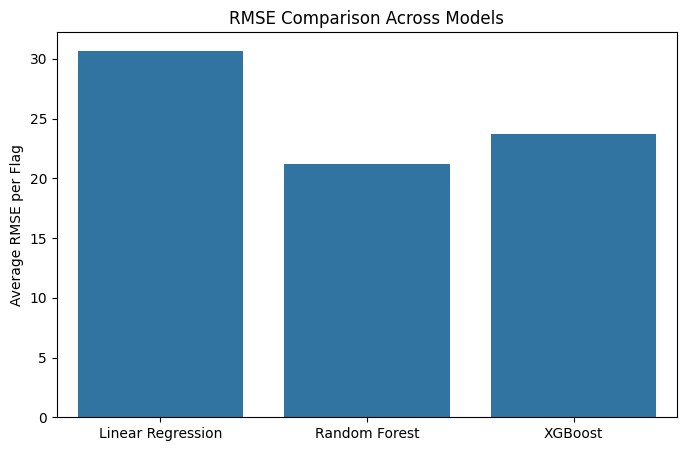

In [29]:
# Root Mean Squared Error (RMSE) Comparison

rmse_scores = {"Linear Regression":lr_rmse,"Random Forest": rf_rmse.mean(), "XGBoost": xgb_rmse.mean()}
plt.figure(figsize=(8, 5))
sns.barplot(x=list(rmse_scores.keys()), y=list(rmse_scores.values()))
plt.ylabel("Average RMSE per Flag")
plt.title("RMSE Comparison Across Models")
plt.show()

In [43]:
# Print a detailed classification report for one model (e.g., Random Forest)

unique_labels = np.unique(y_test)
target_names = le.inverse_transform(unique_labels)
print("Classification Report (Random Forest):")
print(classification_report(y_test, rf_preds, target_names=target_names, zero_division=0))

Classification Report (Random Forest):
              precision    recall  f1-score   support

         AGO       0.66      0.71      0.69      1511
         ALB       0.83      0.80      0.82       146
         ARG       0.98      0.99      0.98     35405
         AUS       0.86      0.89      0.88      4208
         BEL       0.52      0.53      0.53      7819
         BGR       0.97      0.98      0.98      2758
         BLZ       0.28      0.27      0.28      3447
         BRA       0.70      0.69      0.69      2107
         CAN       0.92      0.93      0.92     27206
         CHL       0.94      0.96      0.95     12095
         CHN       0.78      0.85      0.81    227368
         CIV       0.33      0.26      0.29       684
         CMR       0.25      0.29      0.27      1252
         COK       0.49      0.38      0.43      2377
         COL       0.48      0.58      0.52      4209
         CPV       0.10      0.08      0.09       239
         CUB       0.00      0.00      0.0

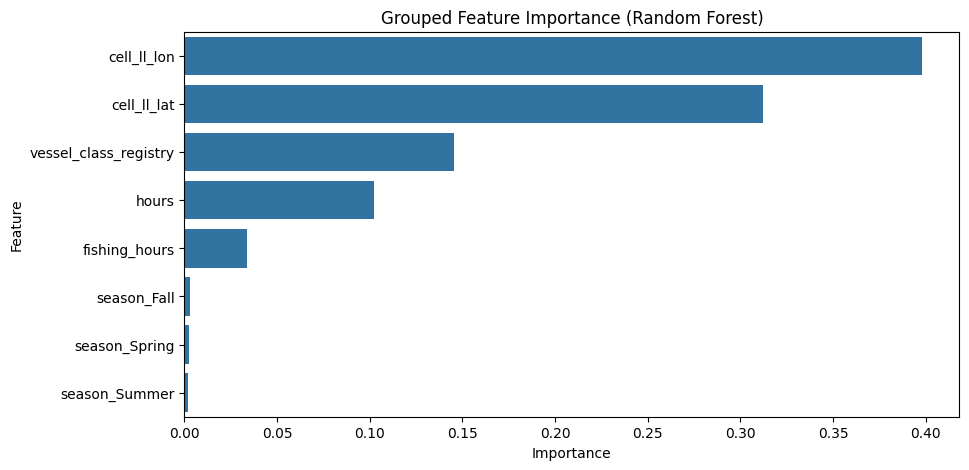

In [45]:
fi = pd.Series(rf_model.estimators_[0].feature_importances_, index=features)
vessel_class_mask = fi.index.str.startswith('vessel_class_registry_')
vessel_class_importance = fi[vessel_class_mask].sum()
fi_grouped = fi[~vessel_class_mask].copy()
fi_grouped['vessel_class_registry'] = vessel_class_importance

fi_grouped = fi_grouped.sort_values(ascending=False)

plt.figure(figsize=(10, 5))
sns.barplot(x=fi_grouped, y=fi_grouped.index)
plt.title("Grouped Feature Importance (Random Forest)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

In [44]:
with open('Flag_Predictions_lr_model.pkl', 'wb') as f:
    pickle.dump(lr_model, f)

with open('Flag_Predicitions_rf_model.pkl', 'wb') as f:
    pickle.dump(rf_model, f)

with open('Flag_Predicitions_xgb_model.pkl', 'wb') as f:
    pickle.dump(xgb_model, f)

print("Models saved as 'Flag_Predicitions_lr_model.pkl', 'Flag_Predicitions_rf_model.pkl', and 'Flag_Predicitions_xgb_model.pkl'.")

Models saved as 'Flag_Predicitions_lr_model.pkl', 'Flag_Predicitions_rf_model.pkl', and 'Flag_Predicitions_xgb_model.pkl'.
